In [1]:
from pathlib import Path
import os
import sys
import json
import copy
import pickle
from hashlib import sha256
import random

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [3]:
sys.path.append('../lared')
from helpers import file_functions
from dataset.example import VideoExample, AudioExample, FullExample
from constants.laughter_constants import data_path, cloud_data_path
from data_loading.utils import get_video_caps, AudioFiles
from coco_reader import CocoReader

In [4]:
cloud_data_path

'/home/jose/drive/data/lared_laughter'

In [5]:
VideoExample.init_caps(get_video_caps('/media/jose/HDD/data/lared/concat'))
VideoExample.init_camera_annotation(os.path.join(cloud_data_path, 'camera.txt'))
AudioExample.init_dataset(AudioFiles('/media/jose/HDD/data/lared/audio/normalized'))

In [6]:
# load ELAN annotations
laughter_ann_path = os.path.join(cloud_data_path, 'laughter.txt')
# path for output images
out_path = os.path.join(cloud_data_path, 'laughter_data')
images_path = os.path.join(out_path, 'images')


laughter_ann = pd.read_csv(laughter_ann_path, sep='\t',names=['name','participant','ini','fin','dur','type'],header=None)
df_laughter_by_participant = laughter_ann.groupby('participant')

In [7]:
dfs_laughter = []
for i in df_laughter_by_participant.groups:
    dfs_laughter.append(df_laughter_by_participant.get_group(i))
participant_ids = df_laughter_by_participant.groups.keys()
participant_ids = [int(id) for id in participant_ids]

In [8]:
sum([len(df) for df in dfs_laughter])

1838

# Apply episode threshold

In [9]:
dfs_laughter[0].tail()

,name,participant,ini,fin,dur,type
62,laughter1,1,6364.76,6365.40,0.64,laughter
63,laughter1,1,6366.04,6366.60,0.56,laughter
64,laughter1,1,6592.00,6593.56,1.56,laughter
65,laughter1,1,6628.40,6629.84,1.44,laughter
66,laughter1,1,6630.84,6631.88,1.04,laughter


In [10]:
# join episodes/bouts that are closer than 1s in time
threshold = 1
num_deleted = 0
num_episodes = 0
for df in dfs_laughter:
    df.reset_index(inplace=True)
    to_delete = []
    for i, row in enumerate(df.iterrows()):
        num_episodes += 1
        if i == len(df)-1: 
            continue
        if (df.loc[i+1, 'ini'] - df.loc[i, 'fin']) < 1:
            df.loc[i+1, 'ini'] = df.loc[i, 'ini']
            to_delete.append(i)
    
    num_deleted += len(to_delete)
    df.drop(to_delete, inplace=True)
print(f'Joined / deleted: {num_deleted} / {num_episodes}')

Joined / deleted: 28 / 1838


/home/jose/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/jose/.local/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
# add prev_fin and next_ini
for df in dfs_laughter:
    df.reset_index(inplace=True)
    prev_fin = []
    next_ini = []
    for i, row in enumerate(df.iterrows()):
        prev_fin.append(0 if i == 0 else df.loc[i-1, 'fin'])
        next_ini.append(1000000 if i == len(df)-1 else df.loc[i+1, 'ini'])
    df.insert(6, 'prev_fin', prev_fin)
    df.insert(7, 'next_ini', next_ini)

In [12]:
sum([len(df) for df in dfs_laughter])

1810

In [13]:
dfs_laughter[0].head()

,level_0,index,name,participant,ini,fin,prev_fin,next_ini,dur,type
0,0,0,laughter1,1,1028.28,1030.08,0.00,1049.98,1.80,laughter
1,1,1,laughter1,1,1049.98,1051.30,1030.08,1099.88,1.32,laughter
2,2,2,laughter1,1,1099.88,1100.84,1051.30,1140.28,0.96,laughter
3,3,3,laughter1,1,1140.28,1142.08,1100.84,1167.02,1.80,laughter
4,4,4,laughter1,1,1167.02,1168.70,1142.08,1242.46,1.68,laughter


# Filter out segments of the interaction

In [14]:
# valid segments
# permisive
# [15:00 - 25:25]
# [27:00 - 40:50]
# [43:00 - 48:42]
# [49:00 - 1:30:35]
# [1:33:00 - 2:44:00]

# strict
# [16:30 - 25:25]
# [28:00 - 40:50]
# [43:00 - 48:42]
# [55:20 - 1:30:35]
# [1:33:00 - 2:44:00]

In [15]:
# checks if an example is within the valid parts of the interaction
# segments of the interaction where people are not in free-for-all were removed (made invalid)
# the fn returns false if the example is within those segments.
def is_valid(s):
    valid_segs = [
        [990, 1525],
        [1680, 2450],
        [2580, 2922],
        [3320, 5435],
        [5580, 9840]
    ]
    for seg in valid_segs:
        if s[0] >= seg[0] and s[1] < seg[1]:
            return True
    return False

def is_valid_row(row):
    return is_valid([row['ini'], row['fin']])

In [16]:
num_kept = 0
num_episodes = 0
for i, df in enumerate(dfs_laughter):
    m = df.apply(is_valid_row, axis=1)
    num_kept += np.sum(m)
    num_episodes += len(m)
    dfs_laughter[i] = df[m]
print(f'Kept: {num_kept} / {num_episodes}')

Kept: 1493 / 1810


# Laughter example: generation

generate the base set of laughter examples

In [17]:
random.seed(22)
np.random.seed(22)

In [18]:
# Pad and split examples
laughter_examples = dict()
camera_distrib = {0: 0, 1:0, 2:0, 3:0, 4:0}
for i, (pid, df_laughter) in tqdm(enumerate(zip(participant_ids, dfs_laughter))):
    for index,row in df_laughter.iterrows():
        ex = FullExample(
            pid= pid,
            ini_time= row['ini'],
            end_time= row['fin'])
        ex.random_pad(1.5, 3.5, min_ini=row['prev_fin'], max_end=row['next_ini'])
        ex.set_camera()
        exs = ex.split_by_camera()
        camera_distrib[len(exs)] += 1

        for example in exs:
            laughter_examples[example.get_hash()] = example

0it [00:00, ?it/s]

<BarContainer object of 5 artists>

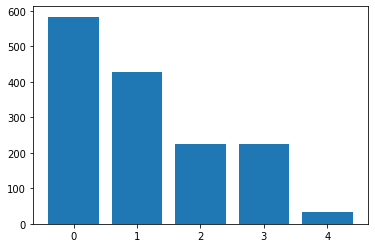

In [19]:
# distribution of num examples among subject IDs
plt.bar(camera_distrib.keys(), camera_distrib.values())

# Laughter examples: loading
load a previously generated set of examples

In [17]:
laughter_examples_df = pd.read_csv(os.path.join(out_path, 'laughter_examples', 'examples.csv'), index_col=0)
laughter_examples = {ex[1].hash: FullExample(**ex[1].to_dict()) for ex in laughter_examples_df.iterrows()}

# Get the distribution

In [18]:
pid_distrib = {pid: 0 for pid in participant_ids}
for ex in laughter_examples.values():
    pid_distrib[ex.pid] += 1

<BarContainer object of 33 artists>

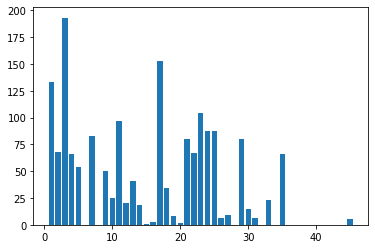

In [19]:
# distribution of num examples among subject IDs
plt.bar(pid_distrib.keys(), pid_distrib.values())

In [20]:
# write images for laughter examples
laughter_images_path = os.path.join(out_path, 'laughter_examples', 'images')
pilot_examples = random.sample(list(laughter_examples.values()), 1000)
for ex in tqdm(pilot_examples):
    ex.write_full_first_image(laughter_images_path)
(len(pilot_examples), len(laughter_examples))

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
audio_path = os.path.join(out_path, 'laughter_examples_comp', 'audio')
video_path = os.path.join(out_path, 'laughter_examples_comp', 'video')
av_path = os.path.join(out_path, 'laughter_examples_comp', 'av')
aiv_path = os.path.join(out_path, 'laughter_examples_comp', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)

In [22]:
coco_reader = CocoReader(os.path.join(out_path, 'laughter_examples', 'cvat.json'))

In [24]:
# write back the bbs
for hash, ex in tqdm(laughter_examples.items()):
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    if not ex.rect:
        continue
    ex.write_audio(audio_path, padded=True)
    # ex.write_audio_video(audio_path, './audio.png', aiv_path)
    ex.write_video(video_path, padded=True)
    ex.write_audiovisual(video_path, audio_path, av_path)

  0%|          | 0/1684 [00:00<?, ?it/s]

TypeError: write_audio() got an unexpected keyword argument 'padded'

In [25]:
examples_dicts = [ex.to_dict() for ex in laughter_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'laughter_data/laughter_examples/examples.csv'))

# Speech / nonspeech segments

In [22]:
%load_ext autoreload
%autoreload 2
import pickle
import random

import numpy as np
import pandas as pd

sys.path.append('../lared')
from dataset.subject import Subject
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
vad_out = '/media/jose/HDD/data/lared/audio/vad'
audio_path = '/media/jose/HDD/data/lared/audio/normalized/'

In [25]:
audiofile_map = pd.read_csv('../lared/dataset/audiofile_map.csv', index_col=0)
audiofile_map.head()

,suffix,ini,end
id,,,
1,01_2,0,6652313
2,02_2,0,6082616
3,03_2,0,6130061
4,04_2,817914,6053613
5,05_2,772051,6430197


In [26]:
subjects=list(audiofile_map.index)

In [27]:
# calculate the pid distribution to get the same proportion of non-laughter segments
num_speech_examples = 430
df_distrib = pd.DataFrame(pid_distrib.items(), columns=['pid', 'num'])
df_distrib = df_distrib.set_index('pid')
df_distrib['num'] = num_speech_examples * df_distrib['num'] / df_distrib['num'].sum()
df_distrib['num'] = df_distrib['num'].round()
df_distrib = df_distrib.astype('uint16')

In [50]:
# for each subject in the dataset
speech_examples = {}
random.seed(22)
np.random.seed(22)
for pid, row in tqdm(audiofile_map.iterrows(), total=audiofile_map.shape[0]):
    pid = int(pid)

    subj = Subject(pid)
    subj.set_audio_path(f'/media/jose/HDD/data/lared/audio/normalized/chan_{row["suffix"]}.wav')
    subj.set_vad_path(f'/media/jose/HDD/data/lared/audio/vad/chan_{row["suffix"]}.vad')
    # subj.load_audio()
    subj.load_vad(row['ini'], row['end'])

    examples = subj.create_speech_thin_slices(df_distrib.loc[pid, 'num'], df_laughter_by_participant.get_group(pid), min_pad=1.5, max_pad=3.5, valid_fn=is_valid)
    for ex in examples:
        ex.set_camera()
        exs = ex.split_by_camera()
        for e in exs:
            speech_examples[e.get_hash()] = e

100%|██████████| 33/33 [01:54<00:00,  3.48s/it]


In [51]:
len(speech_examples)

15400

In [52]:
speech_examples['58e43248514d2338cd6f2bec3c4945c4bc9b99f2cc4dc9e5aa3f5566f4944979']

KeyError: '58e43248514d2338cd6f2bec3c4945c4bc9b99f2cc4dc9e5aa3f5566f4944979'

In [29]:
# write images for speech examples
speech_images_path = os.path.join(out_path, 'speech_examples', 'images')
# pilot_examples = random.sample(list(speech_examples.values()), 60)
for ex in tqdm(speech_examples.values()):
    ex.write_full_first_image(speech_images_path)
# (len(pilot_examples), len(speech_examples))

100%|██████████| 444/444 [00:50<00:00,  8.75it/s]


# Read CVAT annotations

In [34]:
from coco_reader import CocoReader

In [35]:
audio_path = os.path.join(out_path, 'speech_examples', 'audio')
video_path = os.path.join(out_path, 'speech_examples', 'video')
av_path = os.path.join(out_path, 'speech_examples', 'av')
aiv_path = os.path.join(out_path, 'speech_examples', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)
img_path = './audio.png'

In [36]:
coco_reader = CocoReader(os.path.join(out_path, 'speech_examples', 'cvat.json'))

In [37]:
# write back the bbs
for hash, ex in tqdm(speech_examples.items()):
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    ex.write_audio(audio_path)
    ex.write_audio_video(audio_path, img_path, aiv_path)
    ex.write_video(video_path)
    ex.write_audiovisual(video_path, audio_path, av_path)

  0%|          | 0/444 [00:00<?, ?it/s]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  0%|          | 1/444 [00:07<56:11,  7.61s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  0%|          | 2/444 [00:09<31:10,  4.23s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  1%|          | 3/444 [00:10<21:48,  2.97s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  1%|          | 4/444 [00:12<17:52,  2.44s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14

In [38]:
examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'laughter_data/speech_examples/examples.csv'))